In [1]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torchvision import datasets, models
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import seaborn as sns
from torchvision import datasets
from torch.utils.data import DataLoader


In [2]:
# Dataset directory paths
dataset_path = r'D:\university\FER\fer_ckplus_kdef'
train_dir = os.path.join(dataset_path, "train")
val_dir = os.path.join(dataset_path, "val")
test_dir = os.path.join(dataset_path, "test")

# Data augmentation and preprocessing
import torchvision.transforms as transforms

train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(20),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
    transforms.ToTensor(),  # Ensure conversion to tensor before tensor-based transformations
    transforms.RandomErasing(p=0.3),  # Apply only after converting to tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])



val_test_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load datasets
train_dataset = datasets.ImageFolder(train_dir, transform=train_transforms)
val_dataset = datasets.ImageFolder(val_dir, transform=val_test_transforms)
test_dataset = datasets.ImageFolder(test_dir, transform=val_test_transforms)

# Load data with DataLoader
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=4)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=4)


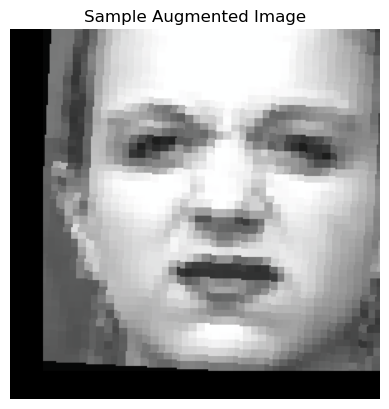

In [3]:
import matplotlib.pyplot as plt
import numpy as np

def show_augmented_sample():
    # Get a batch of training data
    sample_images, _ = next(iter(train_loader))
    
    # Select the first image from the batch
    sample_image = sample_images[0].permute(1, 2, 0).cpu().numpy()
    
    # Denormalize the image
    sample_image = sample_image * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
    sample_image = np.clip(sample_image, 0, 1)

    plt.imshow(sample_image)
    plt.title("Sample Augmented Image")
    plt.axis('off')
    plt.show()

show_augmented_sample()


In [4]:
class FERResNet18(nn.Module):
    def __init__(self, num_classes=8):
        super(FERResNet18, self).__init__()
        self.resnet18 = models.resnet18(pretrained=True)
        
        # Freeze initial layers (optional for fine-tuning)
        for param in self.resnet18.parameters():
            param.requires_grad = False
        
        # Modify fully connected layer for 8 emotion classes
        num_features = self.resnet18.fc.in_features
        self.resnet18.fc = nn.Sequential(
            nn.Linear(num_features, 512),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        return self.resnet18(x)

# Initialize model
model = FERResNet18(num_classes=8)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)


c:\Users\shayon\anaconda3\envs\SHgpu\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\shayon\anaconda3\envs\SHgpu\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


FERResNet18(
  (resnet18): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, trac

In [5]:
# Define loss function
criterion = nn.CrossEntropyLoss()

# Optimizer with weight decay for regularization
optimizer = optim.AdamW(model.parameters(), lr=0.0001, weight_decay=1e-4)

# Learning rate scheduler with cosine annealing
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=50, eta_min=1e-6)


In [6]:
def train_model(model, train_loader, val_loader, num_epochs=50):
    best_val_acc = 0.0

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct, total = 0, 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()

            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

        train_acc = correct / total
        scheduler.step()

        # Validation phase
        model.eval()
        val_correct, val_total = 0, 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                _, preds = torch.max(outputs, 1)
                val_correct += (preds == labels).sum().item()
                val_total += labels.size(0)

        val_acc = val_correct / val_total

        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(train_loader):.4f}, Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}")

        # Save best model
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save(model.state_dict(), "best_fer_model.pth")

    print(f"Best Validation Accuracy: {best_val_acc:.4f}")

train_model(model, train_loader, val_loader, num_epochs=50)


Epoch 1/50, Loss: 1.8634, Train Acc: 0.2964, Val Acc: 0.3630
Epoch 2/50, Loss: 1.7639, Train Acc: 0.3390, Val Acc: 0.3759
Epoch 3/50, Loss: 1.7336, Train Acc: 0.3511, Val Acc: 0.3896
Epoch 4/50, Loss: 1.7210, Train Acc: 0.3547, Val Acc: 0.4151
Epoch 5/50, Loss: 1.6968, Train Acc: 0.3687, Val Acc: 0.4196
Epoch 6/50, Loss: 1.6917, Train Acc: 0.3709, Val Acc: 0.4299
Epoch 7/50, Loss: 1.6858, Train Acc: 0.3730, Val Acc: 0.4200
Epoch 8/50, Loss: 1.6802, Train Acc: 0.3752, Val Acc: 0.4257
Epoch 9/50, Loss: 1.6732, Train Acc: 0.3786, Val Acc: 0.4356
Epoch 10/50, Loss: 1.6634, Train Acc: 0.3838, Val Acc: 0.4189
Epoch 11/50, Loss: 1.6577, Train Acc: 0.3857, Val Acc: 0.4314
Epoch 12/50, Loss: 1.6524, Train Acc: 0.3842, Val Acc: 0.4265
Epoch 13/50, Loss: 1.6524, Train Acc: 0.3878, Val Acc: 0.4234
Epoch 14/50, Loss: 1.6446, Train Acc: 0.3877, Val Acc: 0.4458
Epoch 15/50, Loss: 1.6374, Train Acc: 0.3940, Val Acc: 0.4451
Epoch 16/50, Loss: 1.6360, Train Acc: 0.3936, Val Acc: 0.4246
Epoch 17/50, Loss

KeyboardInterrupt: 

In [ ]:
def evaluate_model(model, test_loader):
    model.load_state_dict(torch.load("best_fer_model.pth"))
    model.eval()
    y_true, y_pred = [], []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())

    acc = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')
    f1 = f1_score(y_true, y_pred, average='weighted')

    print(f"Accuracy: {acc:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")

    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=train_dataset.classes, yticklabels=train_dataset.classes)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()

evaluate_model(model, test_loader)


In [ ]:
dummy_input = torch.randn(1, 3, 224, 224).to(device)
torch.onnx.export(model, dummy_input, "fer_resnet18.onnx")


In [ ]:
torch.save(model.state_dict(), "fer_resnet18_model.pth")
